In [5]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [6]:
# import IPython
# IPython.Application.instance().kernel.do_shutdown(True)

In [7]:
from icevision.all import *

In [8]:
url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip"
dest_dir = "fridge"
data_dir = icedata.load_data(url, dest_dir)

parser = parsers.VOCBBoxParser(annotations_dir=data_dir / "odFridgeObjects/annotations", images_dir=data_dir / "odFridgeObjects/images")

train_records, valid_records = parser.parse()

  0%|          | 0/128 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/128 [00:00<?, ?it/s]

In [11]:
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=(image_size, image_size), presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad((image_size, image_size)), tfms.A.Normalize()])

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [12]:
# Just change the value of selection to try another model

selection = 0

extra_args = {}

if selection == 0:
  model_type = models.mmdet.vfnet
  backbone = model_type.backbones.resnet50_fpn_mstrain_2x
  #model_type = models.mmdet.faster_rcnn
  #backbone = model_type.backbones.resnet50_fpn_1x
  #model_type = models.mmdet.retinanet
  #backbone = model_type.backbones.resnet50_fpn_1x
  #model_type = models.mmdet.ssd
  #backbone = model_type.backbones.ssd512

elif selection == 1:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.faster_rcnn
  backbone = model_type.backbones.resnet50_fpn

elif selection == 2:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_lite1
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 3:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.medium
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

print(model_type, backbone, extra_args)

model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args)

<module 'icevision.models.mmdet.models.vfnet' from '/home/kalfasyan/anaconda3/envs/sahi/lib/python3.9/site-packages/icevision/models/mmdet/models/vfnet/__init__.py'> <icevision.models.mmdet.models.vfnet.backbones.resnet_fpn.MMDetVFNETBackboneConfig object at 0x7fe9744b44c0> {}


  0%|          | 0/131902412 [00:00<?, ?B/s]

2021-12-13 16:05:22,339 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet50'}
2021-12-13 16:05:22,339 - mmcv - INFO - load model from: torchvision://resnet50
2021-12-13 16:05:22,340 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet50
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/kalfasyan/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

2021-12-13 16:05:33,391 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2021-12-13 16:05:33,421 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2021-12-13 16:05:33,446 - mmcv - INFO - initialize VFNetHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01, 'override': {'type': 'Normal', 'name': 'vfnet_cls', 'std': 0.01, 'bias_prob': 0.01}}
2021-12-13 16:05:33,476 - mmcv - INFO - 
backbone.conv1.weight - torch.Size([64, 3, 7, 7]): 
PretrainedInit: load from torchvision://resnet50 
 
2021-12-13 16:05:33,477 - mmcv - INFO - 
backbone.bn1.weight - torch.Size([64]): 
PretrainedInit: load from torchvision://resnet50 
 
2021-12-13 16:05:33,477 - mmcv - INFO - 
backbone.bn1.bias - torch.Size([64]): 
PretrainedInit: load from torchvision://resnet50 
 
2021-12-13 16:05:33,477 - mmcv - INFO - 
backbone.layer1.0.conv1.weight - torch.Size([64, 

load checkpoint from local path: checkpoints/vfnet/vfnet_r50_fpn_mstrain_2x_coco_20201027-7cc75bd2.pth
The model and loaded state dict do not match exactly

size mismatch for bbox_head.vfnet_cls.weight: copying a param with shape torch.Size([80, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([4, 256, 3, 3]).
size mismatch for bbox_head.vfnet_cls.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([4]).


In [13]:
train_dl = model_type.train_dl(train_ds, batch_size=16, num_workers=8, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers=8, shuffle=False)

metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

In [17]:
learn.model

_ModelWrap(
  (model): VFNet(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): ResLayer(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=Tr

/home/kalfasyan/anaconda3/envs/sahi/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


SuggestedLRs(valley=0.0004786300996784121)

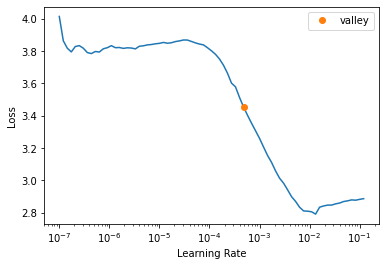

In [14]:
learn.lr_find()

In [15]:
learn.fine_tune(20, 3e-4, freeze_epochs=1)

epoch,train_loss,valid_loss,COCOMetric,time


TypeError: loss() missing 1 required positional argument: 'img_metas'